In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.io import *

In [6]:
path = 'data/mnist/'

In [7]:
import os
os.makedirs(path, exist_ok=True)

In [10]:
URL='http://deeplearning.net/data/mnist/'
FILENAME='mnist.pkl.gz'

def load_mnist(filename):
    return pickle.load(gzip.open(filename, 'rb'), encoding='latin-1')

In [11]:
get_data(URL+FILENAME, path+FILENAME)
((x, y), (x_valid, y_valid), _) = load_mnist(path+FILENAME)

mnist.pkl.gz: 16.2MB [00:19, 826kB/s]                             


In [12]:
type(x), x.shape, type(y), y.shape

(numpy.ndarray, (50000, 784), numpy.ndarray, (50000,))

### Normalize

In [13]:
mean = x.mean()
std = x.std()

In [14]:
x = (x-mean)/std
mean, std, x.mean(), x.std()

(0.13044983, 0.30728981, -3.1638146e-07, 0.99999934)

In [15]:
x_valid = (x_valid-mean)/std
x_valid.mean(), x_valid.std()

(-0.0058509219, 0.99243325)

### Plot helpers

In [16]:
def show(img, title=None):
    plt.imshow(img, cmap="gray")
    if title is not None: plt.title(title)

In [17]:
def plots(ims, figsize=(12,6), rows=2, titles=None):
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], cmap='gray')

### Plots

In [18]:
x_valid.shape

(10000, 784)

In [19]:
x_imgs = np.reshape(x_valid, (-1,28,28)); x_imgs.shape

(10000, 28, 28)

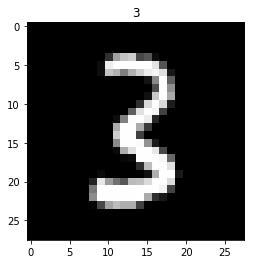

In [20]:
show(x_imgs[0], y_valid[0])

In [21]:
y_valid.shape

(10000,)

In [22]:
y_valid[0]

3

In [23]:
x_imgs[0, 10:15, 10:15]

array([[-0.42452, -0.42452, -0.42452, -0.42452,  0.17294],
       [-0.42452, -0.42452, -0.42452,  0.78312,  2.43567],
       [-0.42452, -0.27197,  1.20261,  2.77889,  2.80432],
       [-0.42452,  1.76194,  2.80432,  2.80432,  1.73651],
       [-0.42452,  2.20685,  2.80432,  2.80432,  0.40176]], dtype=float32)

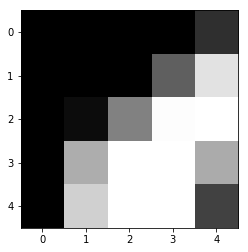

In [24]:
show(x_imgs[0, 10:15, 10:15])

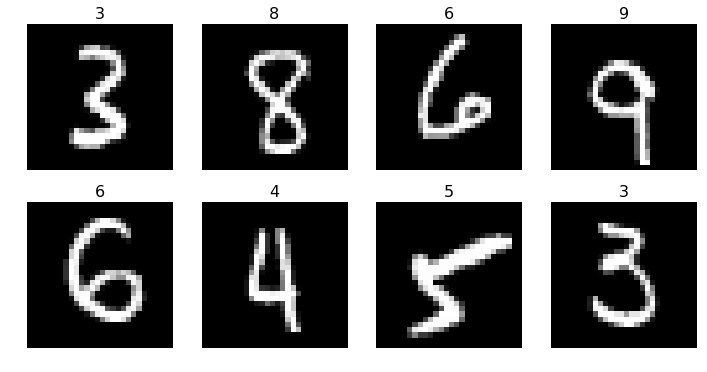

In [25]:
plots(x_imgs[:8], titles = y_valid[:8])